Data loaded successfully from API.

Data Cleaning and Preprocessing...

Top 10 Job Categories:
job_category
Engineering, Architecture, & Planning                                              1012
Health                                                                              561
Engineering, Architecture, & Planning Public Safety, Inspections, & Enforcement     432
Legal Affairs                                                                       415
Finance, Accounting, & Procurement                                                  377
Administration & Human Resources                                                    310
Technology, Data & Innovation                                                       307
Social Services                                                                     269
Public Safety, Inspections, & Enforcement                                           269
Policy, Research & Analysis                                                         259
Name: count,

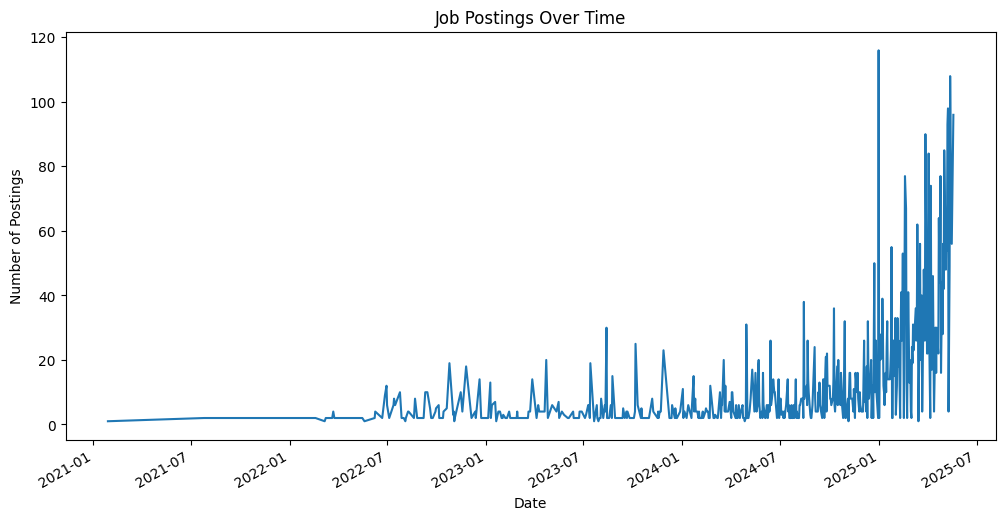

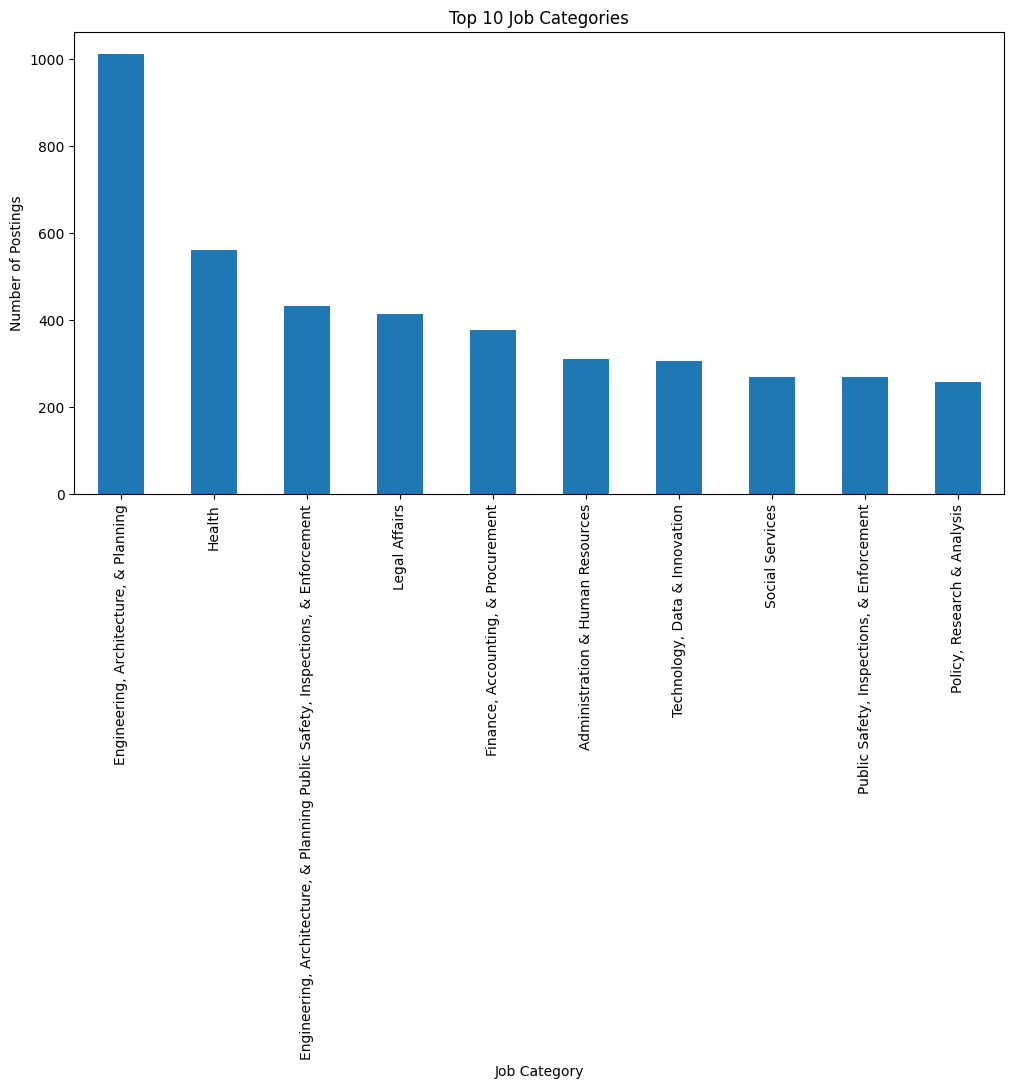


Training and Evaluating Regression Model...
MAE: 12.12, RMSE: 24.55, MAPE: 0.93, R2: 0.04

Predicting and Visualizing Future Trends...

Top Predicted Job Categories:


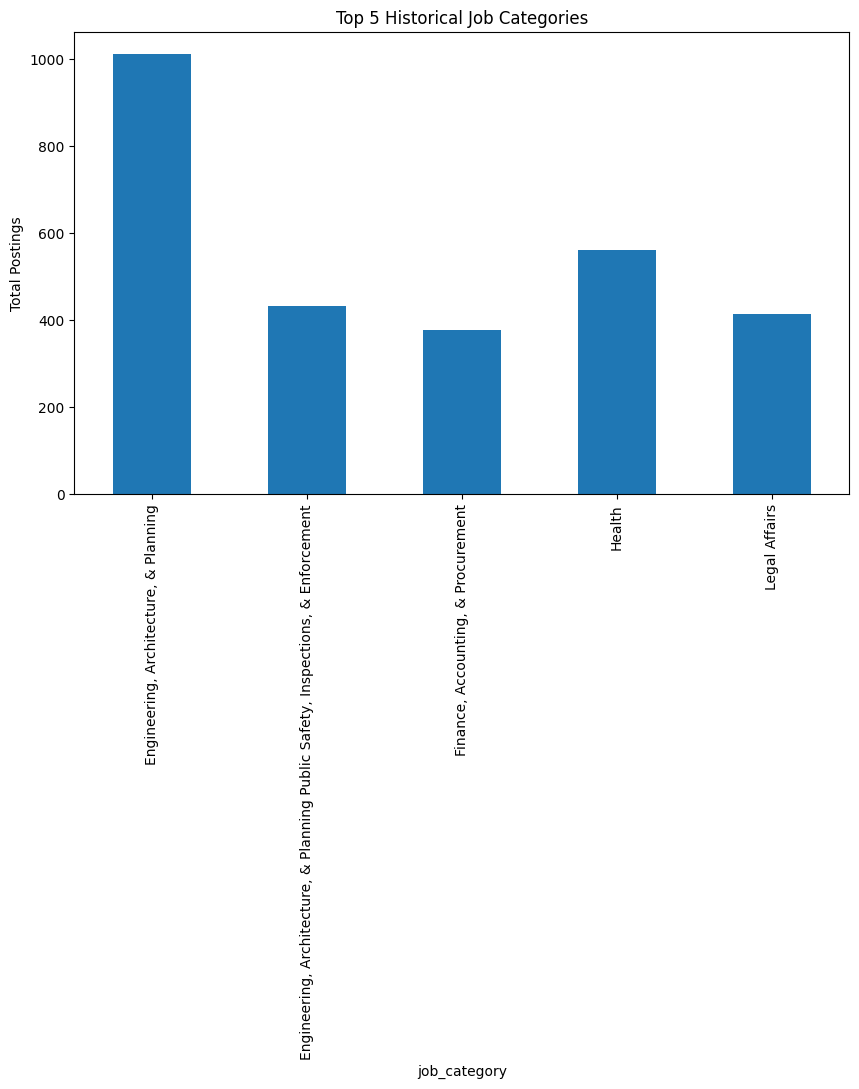

In [3]:
# NYC Job Posting Prediction ML Pipeline - Final Project (Updated for NYC Jobs Postings Dataset)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score,
)
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings("ignore")
import urllib.error
import socket
import time

# 1. Data Loading

def load_and_explore_data(api_url, max_retries=3, retry_delay=5):
    for attempt in range(max_retries):
        try:
            df = pd.read_csv(api_url)
            print("Data loaded successfully from API.")
            return df
        except (urllib.error.URLError, socket.gaierror) as e:
            print(f"Network error: {e}. Retrying in {retry_delay} seconds...")
            time.sleep(retry_delay)
        except Exception as e:
            print(f"Failed to load data: {e}")
            return None
    return None

# 2. Data Cleaning

def clean_and_preprocess_data(df):
    if df is None:
        return None

    print("\nData Cleaning and Preprocessing...")
    df.columns = df.columns.str.lower().str.strip().str.replace(" ", "_")

    if "posting_date" not in df.columns or "job_category" not in df.columns:
        print("Missing required columns.")
        return None

    df["posting_date"] = pd.to_datetime(df["posting_date"], errors="coerce")
    df = df.dropna(subset=["posting_date", "job_category"])

    df["year"] = df["posting_date"].dt.year
    df["month"] = df["posting_date"].dt.month
    df["quarter"] = df["posting_date"].dt.quarter

    print("\nTop 10 Job Categories:")
    print(df["job_category"].value_counts().head(10))

    return df

# 3. EDA

def perform_eda(df):
    if df is None:
        return

    print("\nExploratory Data Analysis...")

    plt.figure(figsize=(12, 6))
    df.groupby("posting_date").size().plot()
    plt.title("Job Postings Over Time")
    plt.xlabel("Date")
    plt.ylabel("Number of Postings")
    plt.show()

    plt.figure(figsize=(12, 6))
    df["job_category"].value_counts().head(10).plot(kind="bar")
    plt.title("Top 10 Job Categories")
    plt.xlabel("Job Category")
    plt.ylabel("Number of Postings")
    plt.show()

# 4. Modeling

def train_and_evaluate_model(df, model_type="regression"):
    if df is None:
        return None

    print(f"\nTraining and Evaluating {model_type.capitalize()} Model...")

    df_agg = df.groupby(["year", "month", "job_category"]).size().reset_index(name="posting_count")
    df_agg["ds"] = pd.to_datetime(df_agg[["year", "month"]].assign(day=1))

    df_regression = pd.get_dummies(df_agg, columns=["job_category"], prefix="job_category")
    test_size = max(12, int(len(df_regression) * 0.2))
    train_data = df_regression.iloc[:-test_size]
    test_data = df_regression.iloc[-test_size:]

    features = [col for col in df_regression.columns if col not in ["ds", "posting_count", "year", "month"]]
    X_train, y_train = train_data[features], train_data["posting_count"]
    X_test, y_test = test_data[features], test_data["posting_count"]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = Ridge(alpha=1.0)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred = np.maximum(0, y_pred)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}, R2: {r2:.2f}")

    return {
        "model": model,
        "features": features,
        "scaler": scaler,
        "df_regression": df_regression,
        "y_true": y_test,
        "y_pred": y_pred,
        "mae": mae,
        "rmse": rmse,
        "mape": mape,
        "r2": r2,
        "model_type": model_type
    }

# 5. Prediction & Visualization

def predict_and_visualize(df, results):
    print("\nPredicting and Visualizing Future Trends...")

    model = results["model"]
    features = results["features"]
    scaler = results["scaler"]
    df_regression = results["df_regression"]

    last_date = df["posting_date"].max()
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=24, freq="MS")
    future_df = pd.DataFrame({"ds": future_dates})
    future_df["year"] = future_df["ds"].dt.year
    future_df["month"] = future_df["ds"].dt.month

    future_expanded = pd.get_dummies(future_df, columns=["year", "month"], prefix_sep="_")
    for col in features:
        if col not in future_expanded.columns:
            future_expanded[col] = 0
    future_expanded = future_expanded[features]

    future_scaled = scaler.transform(future_expanded)
    future_df["predicted_posting_count"] = model.predict(future_scaled)

    print("\nTop Predicted Job Categories:")
    top_jobs = df["job_category"].value_counts().head(5).index
    agg = df[df["job_category"].isin(top_jobs)].groupby("job_category").size()
    agg.plot(kind="bar", figsize=(10,6))
    plt.title("Top 5 Historical Job Categories")
    plt.ylabel("Total Postings")
    plt.show()

# Main Execution

def main():
    api_url = "https://data.cityofnewyork.us/api/views/kpav-sd4t/rows.csv?accessType=DOWNLOAD"
    df = load_and_explore_data(api_url)
    df = clean_and_preprocess_data(df)
    perform_eda(df)
    results = train_and_evaluate_model(df, model_type="regression")
    if results:
        predict_and_visualize(df, results)

if __name__ == "__main__":
    main()